# In-vehicle coupon recommendation
### Classification through Supervised Learning

In [ ]:
#IMPORT LIBRARIES
%%capture
!pip install --force-reinstall numpy==1.23.0

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from sklearn.svm import SVC
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
%%capture
!pip install dython
from dython.nominal import associations

In [ ]:
#IMPORT DATASET
# from google.colab import files
# print("Please select 'in-vehicle-coupon-recommendation.xlsx'\n")
# uploaded = files.upload()

Please select 'in-vehicle-coupon-recommendation.xlsx'



Saving in-vehicle-coupon-recommendation.xlsx to in-vehicle-coupon-recommendation.xlsx


In [ ]:
#READ DATASET
df = pd.read_excel("in-vehicle-coupon-recommendation.xlsx", na_values = '?')

#change category name (for performance in xgboost)
df = df.replace(to_replace = 'Restaurant(<20)', value = 'Restaurant(lt20)')

# Preprocessing

destination - 0 missing values - 0%
passanger - 0 missing values - 0%
weather - 0 missing values - 0%
temperature - 0 missing values - 0%
time - 0 missing values - 0%
coupon - 0 missing values - 0%
expiration - 0 missing values - 0%
gender - 0 missing values - 0%
age - 0 missing values - 0%
maritalStatus - 0 missing values - 0%
has_children - 0 missing values - 0%
education - 0 missing values - 0%
occupation - 0 missing values - 0%
income - 0 missing values - 0%
car - 12576 missing values - 99%
Bar - 107 missing values - 1%
CoffeeHouse - 217 missing values - 2%
CarryAway - 151 missing values - 1%
RestaurantLessThan20 - 130 missing values - 1%
Restaurant20To50 - 189 missing values - 1%
toCoupon_GEQ5min - 0 missing values - 0%
toCoupon_GEQ15min - 0 missing values - 0%
toCoupon_GEQ25min - 0 missing values - 0%
direction_same - 0 missing values - 0%
direction_opp - 0 missing values - 0%
Y - 0 missing values - 0%


<Axes: >

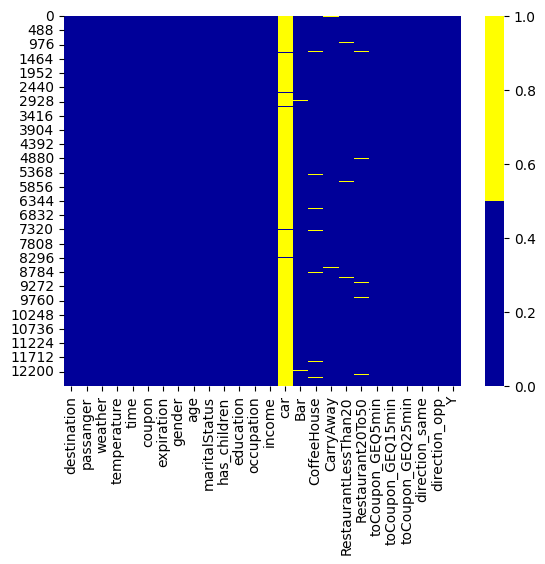

In [ ]:
#MISSING VALUES
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {} missing values - {}%'.format(col, df[col].isnull().sum(), round(pct_missing*100)))

colours = ['#000099', '#ffff00'] # specify the colours
sns.heatmap(df.isnull(), cmap = sns.color_palette(colours))

In [ ]:
#remove car
df = df.drop(['car'], axis = 1)

In [ ]:
#IMPUTING
print("NaN values in dataframe (before imputing): ", df.isnull().sum().sum())
df_num = pd.DataFrame.select_dtypes(df, include = 'int64')
df_obj = pd.DataFrame.select_dtypes(df, include = 'object')
df_cat = df_obj.astype('category')
df_cat_label = df_cat.columns

simp_imp = SimpleImputer(strategy = 'most_frequent')
df_cat = simp_imp.fit_transform(df_cat)
df_cat = pd.DataFrame(df_cat, columns = df_cat_label).astype('category')
df_cat = df_cat.astype("category")
df_num = df_num.astype("float64")

df = pd.concat([df_cat, df_num], axis = 1)
print("NaN values in dataframe (after imputing): ", df.isnull().sum().sum())

NaN values in dataframe (before imputing):  794
NaN values in dataframe (after imputing):  0


In [ ]:
#OUTLIERS
print('Outliers in categorical features:\n')
for column in df_cat.columns:
    print('Frequency of categories for ' + str(column) + ':')
    print(df[column].value_counts(), '\n')

Outliers in categorical features:

Frequency of categories for destination:
No Urgent Place    6283
Home               3237
Work               3164
Name: destination, dtype: int64 

Frequency of categories for passanger:
Alone        7305
Friend(s)    3298
Partner      1075
Kid(s)       1006
Name: passanger, dtype: int64 

Frequency of categories for weather:
Sunny    10069
Snowy     1405
Rainy     1210
Name: weather, dtype: int64 

Frequency of categories for time:
6PM     3230
7AM     3164
10AM    2275
2PM     2009
10PM    2006
Name: time, dtype: int64 

Frequency of categories for coupon:
Coffee House             3996
Restaurant(lt20)         2786
Carry out & Take away    2393
Bar                      2017
Restaurant(20-50)        1492
Name: coupon, dtype: int64 

Frequency of categories for expiration:
1d    7091
2h    5593
Name: expiration, dtype: int64 

Frequency of categories for gender:
Female    6511
Male      6173
Name: gender, dtype: int64 

Frequency of categories for age:

Outliers in numerical features:

temperature statistics: 
 count    12684.000000
mean        63.301798
std         19.154486
min         30.000000
25%         55.000000
50%         80.000000
75%         80.000000
max         80.000000
Name: temperature, dtype: float64


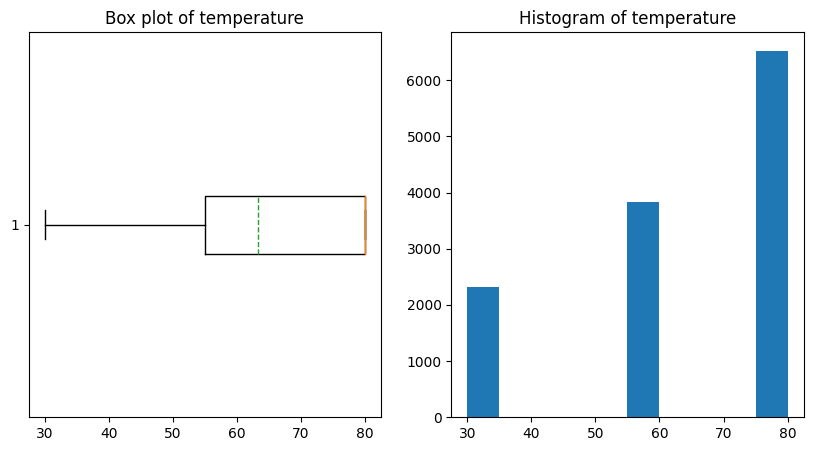

has_children has 0 outliers
toCoupon_GEQ5min has 0 outliers
toCoupon_GEQ15min has 0 outliers
toCoupon_GEQ25min has 0 outliers
direction_same has 0 outliers
direction_opp has 0 outliers
Y has 0 outliers


 Standard deviations:
temperature 19.154485756840632
has_children 0.49259297975549976
toCoupon_GEQ5min 0.0
toCoupon_GEQ15min 0.49622354161496957
toCoupon_GEQ25min 0.32395002563525804
direction_same 0.41067106826403527
direction_opp 0.41067106826403527
Y 0.495314356461185


In [ ]:
print('Outliers in numerical features:\n')
for column in df_num.columns:
    if column == 'temperature':
        print(str(column) + ' statistics: \n', df[column].describe())
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.boxplot(df[column], showmeans = True, meanline = True, vert = False)
        ax1.set_title('Box plot of ' + str(column))
        ax2.hist(df[column].values)
        ax2.set_title('Histogram of ' + str(column))
        plt.show()
    else:
        print(str(column), np.where(np.any(list(df[column] != 1.) and np.any(list(df[column]) != 0.)),
                                    'has 0 outliers', 'has at least 1 outlier'))

#standard deviation of numerical features
print('\n\n Standard deviations:')
for column in df_num.columns:
    print(str(column), df[column].std())

In [ ]:
#remove toCoupon_GEQ5min
df = df.drop(['toCoupon_GEQ5min'], axis = 1)

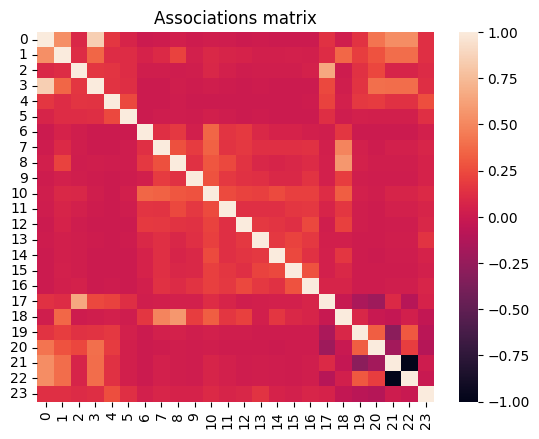

Columns with |association|>0.65:
 ['destination', 'time', 'direction_same', 'direction_opp']


In [ ]:
#FEATURE IMPORTANCE
#list of numbers between 1 and the number of features
n = df.shape[1]
output = []
for i in range(0, n):
    output.append(i)

complete_correlation = associations(df, compute_only = True)
df_complete_corr = complete_correlation['corr'].astype("float64")
plt.figure()
sns.heatmap(df_complete_corr, xticklabels = output, yticklabels = output)
plt.title('Associations matrix')
plt.show()

thres = 0.65
corr_matrix = df_complete_corr.values
rows, cols = np.where(np.abs(corr_matrix) > thres)
index = np.where(rows != cols)
rows_to_drop = rows[index]
cols_to_drop = cols[index]

print('Columns with |association| > ' + str(thres) + ':\n', list(df.columns[rows_to_drop]))

In [ ]:
#remove destination and direction_same
df = df.drop(['destination', 'direction_same'], axis = 1)

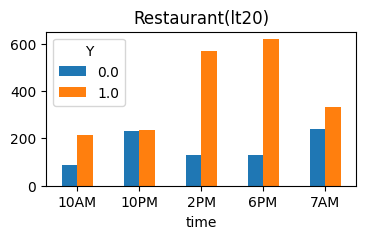

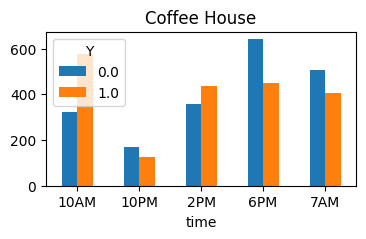

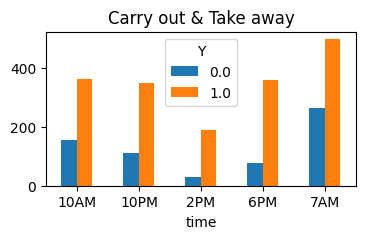

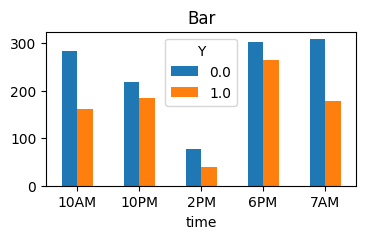

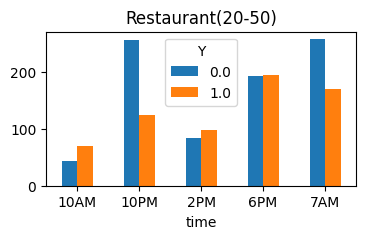

In [ ]:
#NOTABLE LINKS AMONG DATA
#create a dictionary of dataframes
options = list(df['coupon'].unique())
dic = dict()
for option in options:
    dic[option] = df[df.coupon == option]
    dic[option] = pd.DataFrame(dic[option], columns = df.columns)

#correlation and bar plot
for option in options:
    CrosstabResult = pd.crosstab(index = dic[option]['time'],
                                 columns = dic[option]['Y'])
    CrosstabResult.plot.bar(figsize=(4,2), rot = 0)
    plt.title(option)

In [ ]:
#CATEGORICAL FEATURES
print('dtypes before:\n', df.dtypes)
df = pd.get_dummies(df)
print('\n\ndtypes after:\n', df.dtypes)

dtypes before:
 passanger               category
weather                 category
time                    category
coupon                  category
expiration              category
gender                  category
age                     category
maritalStatus           category
education               category
occupation              category
income                  category
Bar                     category
CoffeeHouse             category
CarryAway               category
RestaurantLessThan20    category
Restaurant20To50        category
temperature              float64
has_children             float64
toCoupon_GEQ15min        float64
toCoupon_GEQ25min        float64
direction_opp            float64
Y                        float64
dtype: object


dtypes after:
 temperature               float64
has_children              float64
toCoupon_GEQ15min         float64
toCoupon_GEQ25min         float64
direction_opp             float64
                           ...   
Restaurant20To50_1~3   

In [ ]:
#SCALING
scaler = MinMaxScaler(feature_range = (0, 1))
scaler = scaler.fit_transform(df)
df = pd.DataFrame(scaler, columns = df.columns)

In [ ]:
#TRAIN-TEST SPLIT
df_train, df_test = train_test_split(df, test_size = 0.1)
target_train = df_train['Y']
target_train = pd.Series.astype(target_train, dtype = np.int32)
target_test = df_test['Y']
target_test = pd.Series.astype(target_test, dtype = np.int32)
df_train = df_train.drop(labels='Y', axis = 1)
df_test = df_test.drop(labels='Y', axis = 1)

# Classification

In [ ]:
#FUNCTIONS
#calculate classification metrics
def metrics(true, pred, prob_pred, classifier):
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred, average = 'macro')
    recall = recall_score(true, pred, average = 'macro')
    f1 = f1_score(true, pred, average = 'macro')
    logloss = log_loss(true, prob_pred, eps = 1e-15)
    auc = roc_auc_score(true, prob_pred[:, 1])
    data_metrics = pd.DataFrame(np.array([[accuracy], [precision], [recall], [f1], [logloss], [auc]]).T,
                                columns = ['accuracy', 'precision', 'recall', 'f1', 'log loss', 'AUC'])
    data_class = pd.DataFrame([classifier], columns = ['classifier'])
    dataframe = pd.concat([data_class, data_metrics], axis = 1)
    return dataframe

#calculate classification metrics when predict_proba is not available (ridge classifier)
def metrics2(true, pred, classifier):
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred, average = 'macro')
    recall = recall_score(true, pred, average = 'macro')
    f1 = f1_score(true, pred, average = 'macro')
    logloss = np.nan
    auc = np.nan
    data_metrics = pd.DataFrame(np.array([[accuracy], [precision], [recall], [f1], [logloss], [auc]]).T,
                                columns = ['accuracy', 'precision', 'recall', 'f1', 'log loss', 'AUC'])
    data_class = pd.DataFrame([classifier], columns = ['classifier'])
    dataframe = pd.concat([data_class, data_metrics], axis = 1)
    return dataframe

#plot confusion matrix and ROC curve
def plots(target_test, pred, classifier):
    conf_display = ConfusionMatrixDisplay.from_predictions(target_test, pred)
    roc_display = RocCurveDisplay.from_predictions(target_test, pred)
    plt.close('all')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(classifier)
    conf_display.plot(ax = ax1)
    roc_display.plot(ax = ax2)
    ax1.set_title('Confusion matrix')
    ax2.set_title('ROC Curve')
    plt.show()

#create metrics_df
metrics_df = pd.DataFrame(columns = ['classifier', 'accuracy', 'precision', 'recall', 'f1', 'log loss', 'AUC'])
print(metrics_df)

#update metrics_df
def conc(metrics_df, metr, title):
    if (title in metrics_df['classifier'].unique()) == False:
        metrics_df = pd.concat([metrics_df, metr], ignore_index = True)
    else:
        ind = metrics_df.index[metrics_df['classifier'] == title].tolist()
        metr_data = pd.DataFrame(metr, columns = ['classifier', 'accuracy', 'precision', 'recall', 'f1', 'log loss', 'AUC'], index = ind)
        metrics_df.update(metr_data)
    return metrics_df

Empty DataFrame
Columns: [classifier, accuracy, precision, recall, f1, log loss, AUC]
Index: []


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Classification report:
               precision    recall  f1-score   support

           0       0.49      0.31      0.38       563
           1       0.57      0.74      0.65       706

    accuracy                           0.55      1269
   macro avg       0.53      0.53      0.51      1269
weighted avg       0.54      0.55      0.53      1269



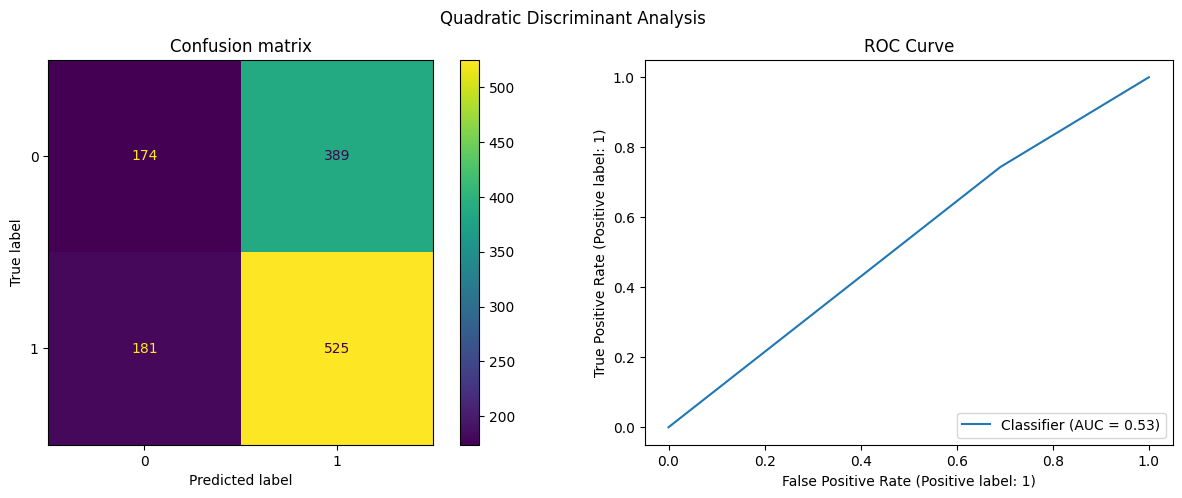

In [ ]:
#QUADRATIC DISCRIMINANT ANALYSIS
qda = QuadraticDiscriminantAnalysis()
title = 'Quadratic Discriminant Analysis'
qda.fit(df_train, target_train)
pred = qda.predict(df_test)
prob_pred = qda.predict_proba(df_test)
print('Classification report:\n', classification_report(target_test, pred,
                                                        output_dict = False))
plots(target_test, pred, title)
metr = metrics(target_test, pred, prob_pred, title)
metrics_df = conc(metrics_df, metr, title)

Classification report:
               precision    recall  f1-score   support

           0       0.57      0.62      0.59       563
           1       0.67      0.62      0.65       706

    accuracy                           0.62      1269
   macro avg       0.62      0.62      0.62      1269
weighted avg       0.63      0.62      0.62      1269



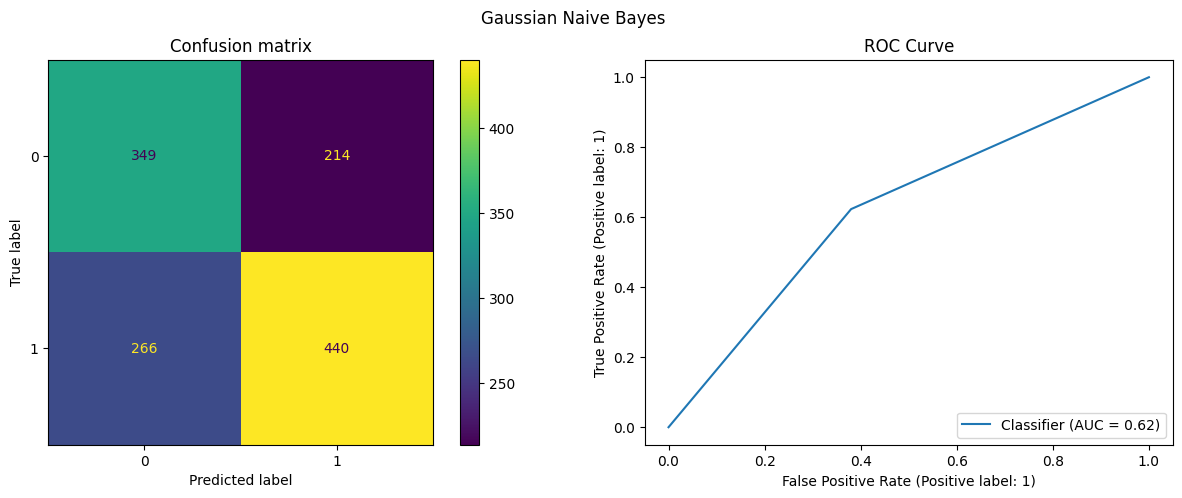

In [ ]:
#GAUSSIAN NAIVE BAYES
gnb = GaussianNB()
title = 'Gaussian Naive Bayes'
gnb.fit(df_train, target_train)
pred = gnb.predict(df_test)
prob_pred = gnb.predict_proba(df_test)
print('Classification report:\n', classification_report(target_test, pred,
                                                        output_dict = False))
plots(target_test, pred, title)
metr = metrics(target_test, pred, prob_pred, title)
metrics_df = conc(metrics_df, metr, title)

In [ ]:
#k-NEAREST NEIGHBORS
parameters = {'n_neighbors': range(3, 11, 2)}
neigh = KNeighborsClassifier()
clf = GridSearchCV(estimator = neigh, param_grid = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters:', clf.best_params_, '\n Score:', clf.best_score_)

Best parameters: {'n_neighbors': 5} 
 Score: 0.6784932106876915


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d1d92b15090>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error



Number of neighbors: 5 

 Classification report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63       563
           1       0.70      0.74      0.72       706

    accuracy                           0.68      1269
   macro avg       0.68      0.67      0.68      1269
weighted avg       0.68      0.68      0.68      1269



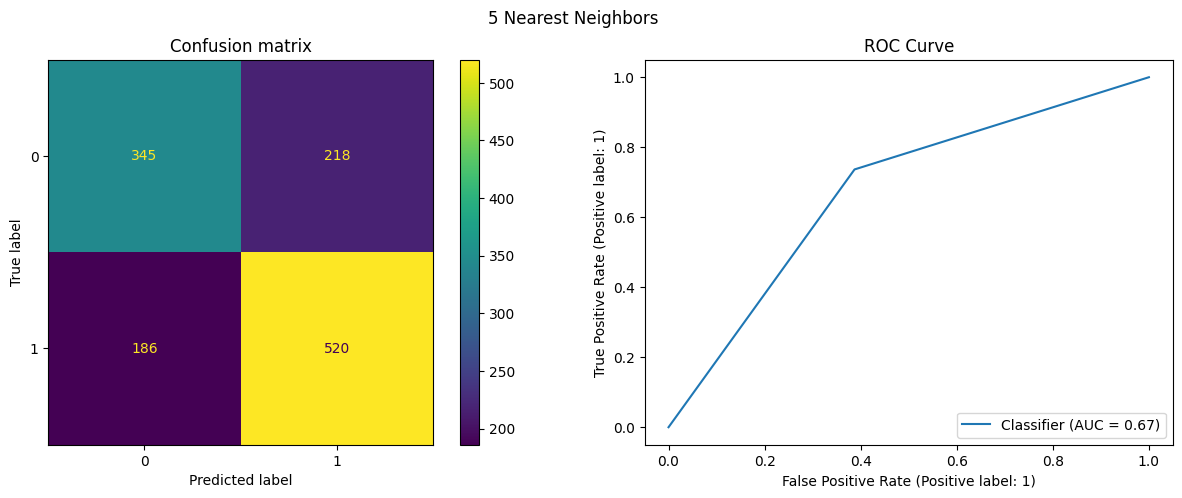

In [ ]:
#k-NEAREST NEIGHBORS II
k = clf.best_params_['n_neighbors']
neigh3 = KNeighborsClassifier(n_neighbors = k)
title = str(k) + ' Nearest Neighbors'
neigh3.fit(df_train, target_train)
pred = neigh3.predict(df_test)
prob_pred = neigh3.predict_proba(df_test)
print('\nNumber of neighbors:', k, '\n\n Classification report:\n',
      classification_report(target_test, pred, output_dict = False))
plots(target_test, pred, title)
metr = metrics(target_test, pred, prob_pred, title)
metrics_df = conc(metrics_df, metr, title)

In [ ]:
#ridge classifier
parameters = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
clf = RidgeClassifier()
clf = GridSearchCV(estimator = clf, param_grid = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters for Ridge Classifier:', clf.best_params_,
      '\n Score:', clf.best_score_)

Best parameters for Ridge Classifier: {'alpha': 0.6} 
 Score: 0.6826982041173895


Alpha: 0.6 

 Classification report:
               precision    recall  f1-score   support

           0       0.66      0.55      0.60       563
           1       0.68      0.77      0.73       706

    accuracy                           0.68      1269
   macro avg       0.67      0.66      0.66      1269
weighted avg       0.67      0.68      0.67      1269



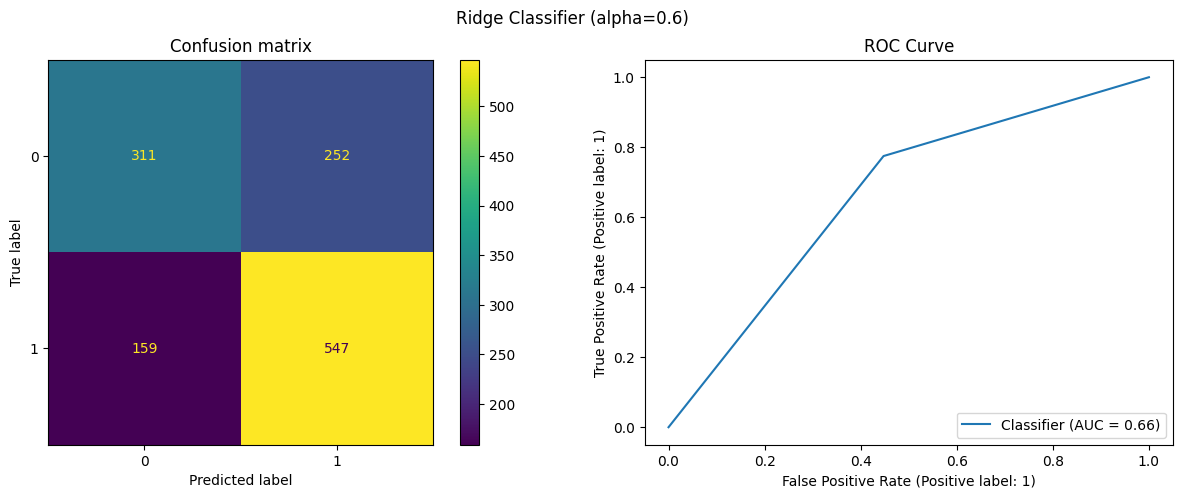

In [ ]:
#RIDGE CLASSIFIER II
k = clf.best_params_['alpha']
RidgeClassifier = RidgeClassifier(alpha = k)
title = 'Ridge Classifier (alpha=' + str(k) + ')'
RidgeClassifier.fit(df_train, target_train)
pred = RidgeClassifier.predict(df_test)
print('Alpha:', k, '\n\n Classification report:\n',
      classification_report(target_test, pred, output_dict = False))
plots(target_test, pred, title)
metr = metrics2(target_test, pred, title)
metrics_df = conc(metrics_df, metr, title)

In [ ]:
#logistic regression
parameters = {'C': [100, 10, 1.0, 0.1, 0.01]}
clf = LogisticRegression(max_iter = 1000)
clf = GridSearchCV(estimator = clf, param_grid = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters for Logistic Regression Classifier:', clf.best_params_,
      '\n Score:', clf.best_score_)

Best parameters for Logistic Regression Classifier: {'C': 0.1} 
 Score: 0.6840122645641699


C: 0.1 

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.55      0.60       563
           1       0.69      0.78      0.73       706

    accuracy                           0.68      1269
   macro avg       0.67      0.67      0.67      1269
weighted avg       0.68      0.68      0.67      1269



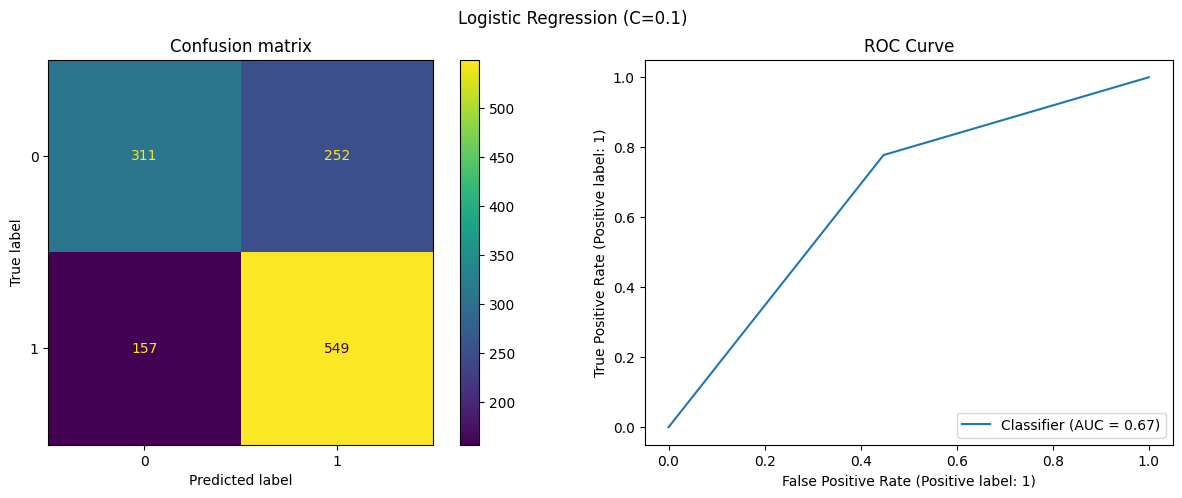

In [ ]:
#logistic regression II
k = clf.best_params_['C']
logreg = LogisticRegression(C = k, max_iter = 1000)
title = 'Logistic Regression (C=' + str(k) + ')'
logreg.fit(df_train, target_train)
pred = logreg.predict(df_test)
prob_pred = logreg.predict_proba(df_test)
print('C:', k, '\n\nClassification report:\n',
      classification_report(target_test, pred, output_dict = False))
plots(target_test, pred, title)
metr = metrics(target_test, pred, prob_pred, title)
metrics_df = conc(metrics_df, metr, title)

In [ ]:
#Decision tree
parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [3, 7, 18, 22, 36, 48]}
clf = DecisionTreeClassifier()
clf = RandomizedSearchCV(estimator = clf, param_distributions = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters for Decision Tree:', clf.best_params_,
      '\n Score:', clf.best_score_)

Best parameters for Decision Tree: {'max_depth': 7, 'criterion': 'log_loss'} 
 Score: 0.6906701708278581


criterion: log_loss 
max_depth: 7 

Classification report:
               precision    recall  f1-score   support

           0       0.68      0.57      0.62       563
           1       0.70      0.79      0.74       706

    accuracy                           0.69      1269
   macro avg       0.69      0.68      0.68      1269
weighted avg       0.69      0.69      0.69      1269



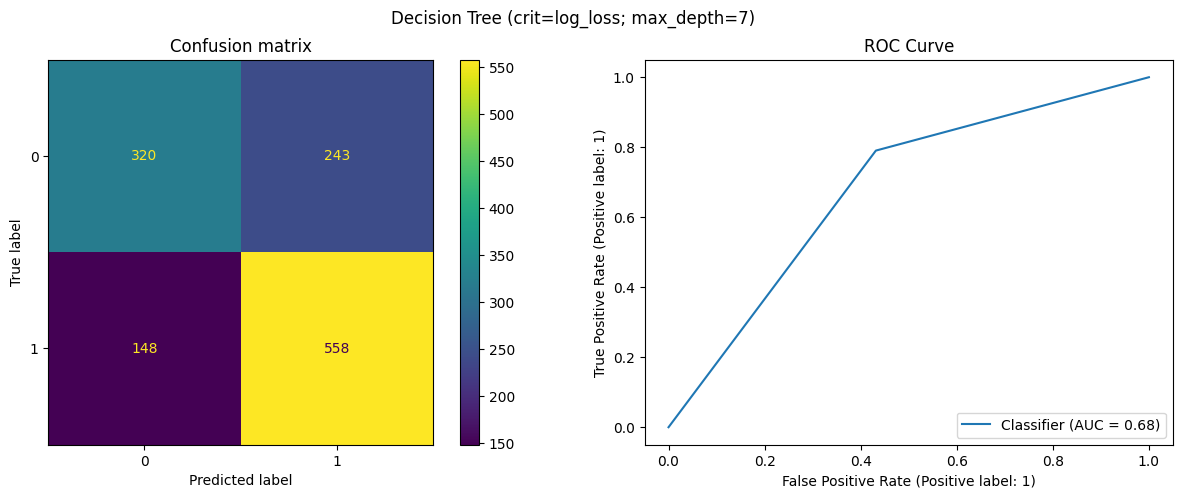

In [ ]:
#decision tree II
k = clf.best_params_['criterion']
md = clf.best_params_['max_depth']
dectree = DecisionTreeClassifier(criterion = k, max_depth = md)
title = 'Decision Tree (crit=' + str(k) + '; max_depth=' + str(md) + ')'
dectree.fit(df_train, target_train)
pred = dectree.predict(df_test)
prod_pred = dectree.predict_proba(df_test)
print('criterion:', k, '\nmax_depth:', md, '\n\nClassification report:\n',
      classification_report(target_test, pred, output_dict = False))
plots(target_test, pred, title)
metr = metrics(target_test, pred, prob_pred, title)
metrics_df = conc(metrics_df, metr, title)

In [ ]:
#MLP classifier
parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu']}
clf = MLPClassifier([64, 64], batch_size = 64, max_iter = 1000)
clf = GridSearchCV(estimator = clf, param_grid = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters for MLP clssifier:', clf.best_params_,
      '\n Score:', clf.best_score_)

Best parameters for MLP clssifier: {'activation': 'tanh'} 
 Score: 0.7328953131844066


Classification report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.69       563
           1       0.75      0.77      0.76       706

    accuracy                           0.73      1269
   macro avg       0.73      0.73      0.73      1269
weighted avg       0.73      0.73      0.73      1269



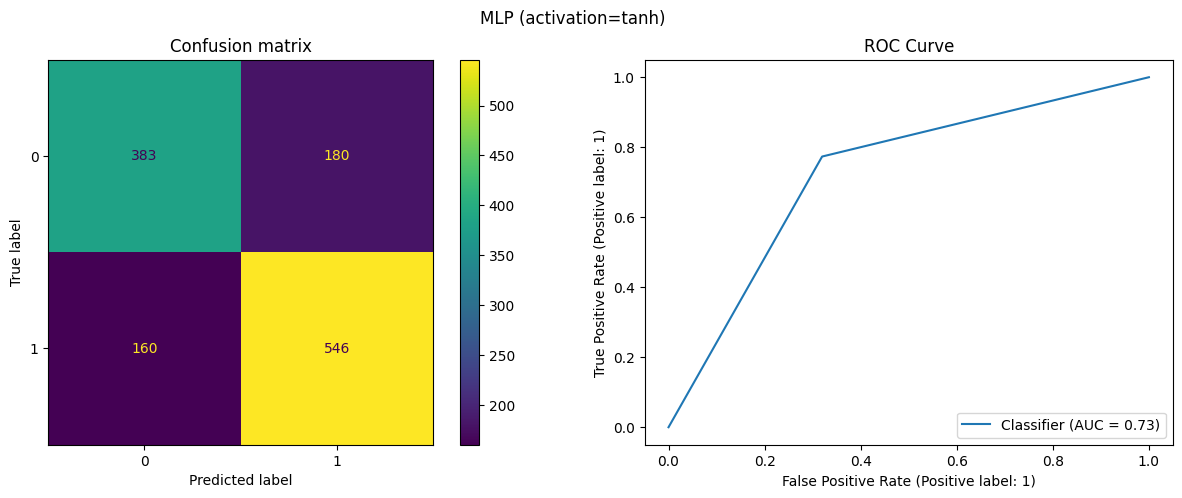

In [ ]:
#MPL classifier II
k = clf.best_params_['activation']
mlp = MLPClassifier([64, 64], activation = k, batch_size = 64, max_iter = 1000)
title = 'MLP (activation=' + str(k) + ')'
mlp.fit(df_train, target_train)
pred = mlp.predict(df_test)
prob_pred = mlp.predict_proba(df_test)
print('Classification report:\n', classification_report(target_test, pred, output_dict = False))
plots(target_test, pred, title)
metr = metrics(target_test, pred, prob_pred, title)
metrics_df = conc(metrics_df, metr, title)

In [ ]:
#random forest
parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
              'n_estimators': np.arange(50, 200, 15),
              'max_depth': [3, 5, 7, 9]}
clf = RandomForestClassifier()
clf = RandomizedSearchCV(estimator = clf, param_distributions = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters for Random Forest:', clf.best_params_,
      '\n Score:', clf.best_score_)

Best parameters for Random Forest: {'n_estimators': 95, 'max_depth': 9, 'criterion': 'log_loss'} 
 Score: 0.7252737625930793


Classification report:
               precision    recall  f1-score   support

           0       0.76      0.58      0.66       563
           1       0.72      0.85      0.78       706

    accuracy                           0.73      1269
   macro avg       0.74      0.72      0.72      1269
weighted avg       0.74      0.73      0.72      1269



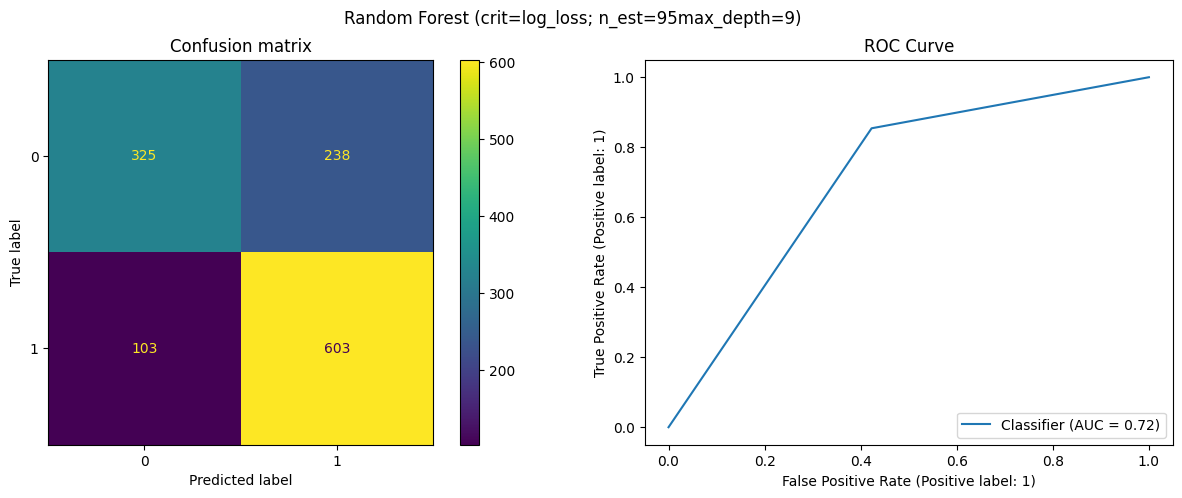

In [ ]:
#random forest II
k = clf.best_params_['criterion']
ne = clf.best_params_['n_estimators']
md = clf.best_params_['max_depth']
rf = RandomForestClassifier(criterion = k, n_estimators = ne,
                            max_depth = md, n_jobs = 8)
title = 'Random Forest (crit=' + str(k) + '; n_est=' + str(ne) + 'max_depth=' + str(md) +')'
rf.fit(df_train, target_train)
pred = rf.predict(df_test)
prob_pred = rf.predict_proba(df_test)
print('Classification report:\n', classification_report(target_test, pred, output_dict = False))
plots(target_test, pred, title)
metr = metrics(target_test, pred, prob_pred, title)
metrics_df = conc(metrics_df, metr, title)

In [ ]:
#Support Vector Classifier
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': list(range(2,6)),
              'gamma': ['scale', 'auto']}
svc = SVC()
clf = RandomizedSearchCV(estimator = svc, param_distributions = parameters, n_jobs = 8)
clf.fit(df_train, target_train)
print('Best parameters for Random Forest:', clf.best_params_,
      '\n Score:', clf.best_score_)

Best parameters for Random Forest: {'kernel': 'poly', 'gamma': 'scale', 'degree': 5} 
 Score: 0.7681121331581252


Classification report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       563
           1       0.77      0.80      0.79       706

    accuracy                           0.76      1269
   macro avg       0.75      0.75      0.75      1269
weighted avg       0.76      0.76      0.76      1269



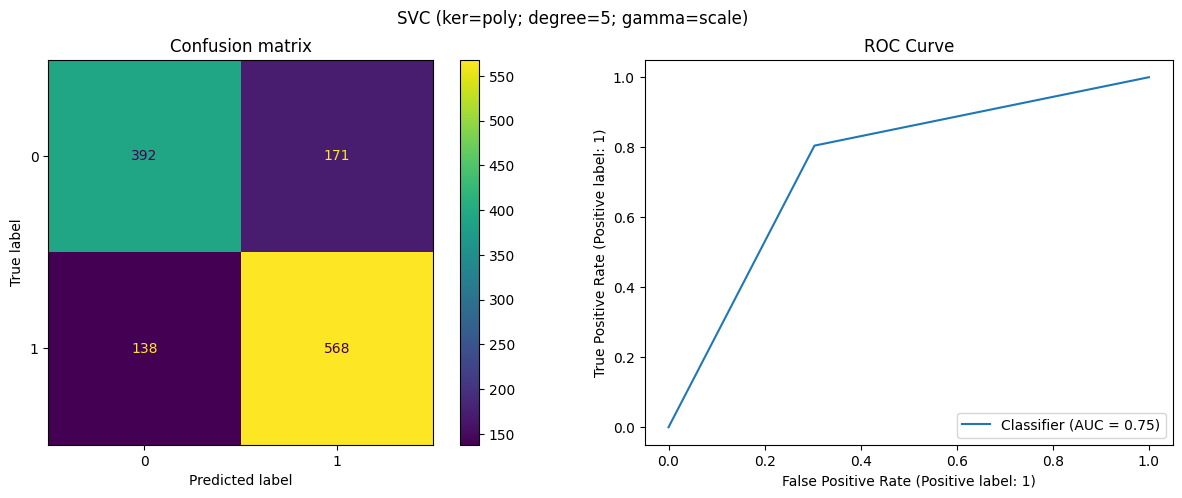

In [ ]:
#SVC II
ker = clf.best_params_['kernel']
deg = clf.best_params_['degree']
gam = clf.best_params_['gamma']
svc = SVC(kernel = ker, degree = deg, gamma = gam, probability = True)
title = 'SVC (ker=' + str(ker) + '; degree=' + str(deg) + '; gamma=' + str(gam) + ')'
svc.fit(df_train, target_train)
pred = svc.predict(df_test)
prob_pred = svc.predict_proba(df_test)
print('Classification report:\n', classification_report(target_test, pred, output_dict = False))
plots(target_test, pred, title)
metr = metrics(target_test, pred, prob_pred, title)
metrics_df = conc(metrics_df, metr, title)

Classification report:
               precision    recall  f1-score   support

           0       0.71      0.37      0.49       563
           1       0.64      0.88      0.74       706

    accuracy                           0.65      1269
   macro avg       0.68      0.63      0.61      1269
weighted avg       0.67      0.65      0.63      1269



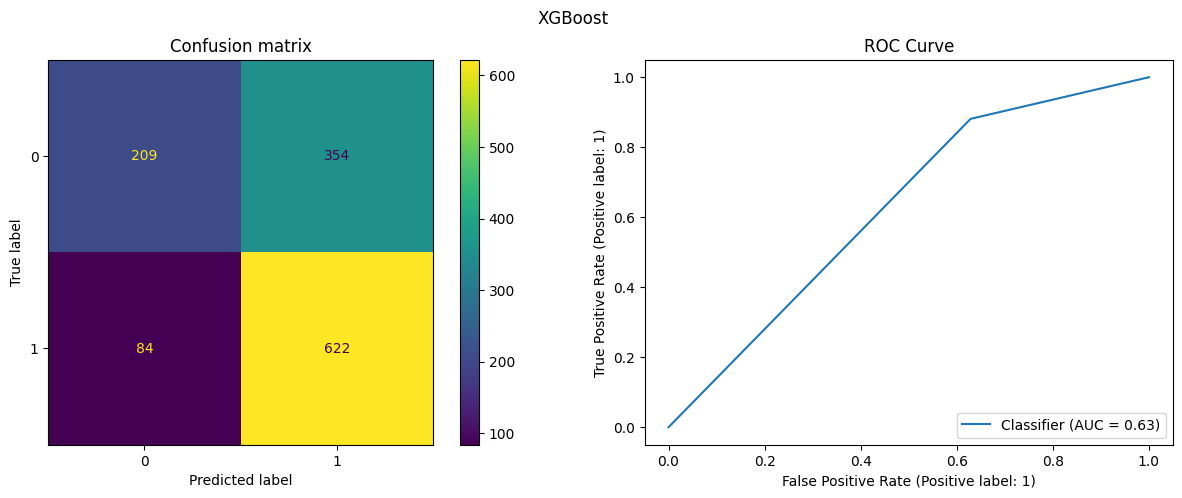

In [ ]:
#XGBOOST
bst = XGBClassifier(n_estimators = 2, max_depth = 2, learning_rate = 1,
                    objective = 'binary:logistic')
title = 'XGBoost'
bst.fit(df_train, target_train)
pred = bst.predict(df_test)
prob_pred = bst.predict_proba(df_test)
print('Classification report:\n', classification_report(target_test, pred, output_dict = False))
plots(target_test, pred, title)
metr = metrics(target_test, pred, prob_pred, title)
metrics_df = conc(metrics_df, metr, title)

#Results

In [ ]:
#TABLE
metrics_df

,classifier,accuracy,precision,recall,f1,log loss,AUC
0,Quadratic Discriminant Analysis,0.550827,0.532270,0.526342,0.513617,11.238867,0.535269
1,Gaussian Naive Bayes,0.621749,0.620131,0.621561,0.619794,2.092517,0.650332
2,5 Nearest Neighbors,0.681639,0.677162,0.674666,0.675467,1.506008,0.729861
3,Ridge Classifier (alpha=0.6),0.676123,0.673154,0.663593,0.664520,NaN,NaN
4,Logistic Regression (C=0.1),0.677699,0.674962,0.665009,0.665949,0.604957,0.727707
5,Decision Tree (crit=log_loss; max_depth=7),0.691883,0.690195,0.679376,0.680650,0.604957,0.727707
6,MLP (activation=tanh),0.732072,0.728703,0.726828,0.727578,1.651787,0.815392
7,Random Forest (crit=log_loss; n_est=95max_dept...,0.731284,0.738175,0.715686,0.717738,0.578730,0.787361
8,SVC (ker=poly; degree=5; gamma=scale),0.756501,0.754114,0.750401,0.751726,0.492546,0.837466
9,XGBoost,0.654846,0.675303,0.626123,0.613957,0.624041,0.694326


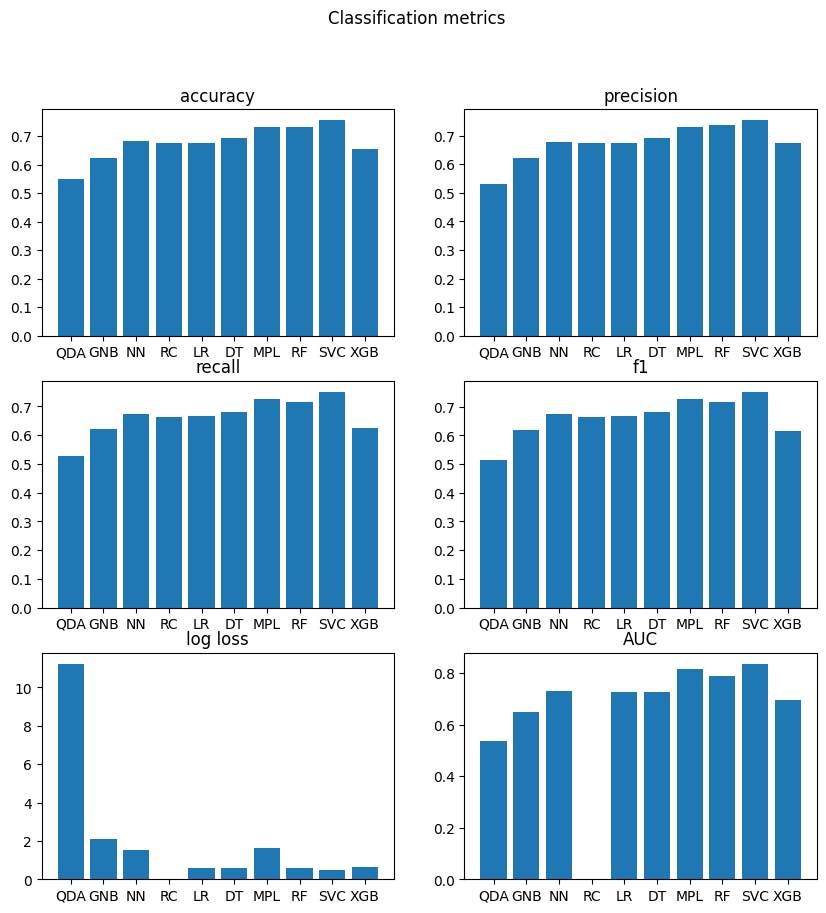

In [ ]:
#BAR PLOTS
names=metrics_df['classifier']
metrics_df['classifier']=['QDA', 'GNB', 'NN', 'RC', 'LR', 'DT', 'MPL', 'RF', 'SVC', 'XGB']

fig, axs = plt.subplots(3, 2, figsize=(10,10))
fig.suptitle('Classification metrics')
axs[0, 0].bar(metrics_df['classifier'], metrics_df['accuracy'])
axs[0, 0].set_title('accuracy')
axs[0, 1].bar(metrics_df['classifier'], metrics_df['precision'])
axs[0, 1].set_title('precision')
axs[1, 0].bar(metrics_df['classifier'], metrics_df['recall'])
axs[1, 0].set_title('recall')
axs[1, 1].bar(metrics_df['classifier'], metrics_df['f1'])
axs[1, 1].set_title('f1')
axs[2, 0].bar(metrics_df['classifier'], metrics_df['log loss'])
axs[2, 0].set_title('log loss')
axs[2, 1].bar(metrics_df['classifier'], metrics_df['AUC'])
axs[2, 1].set_title('AUC')
plt.show()